# Schriftliche Ausarbeitung Learning & Softcomputing

### Einleitung

Im Zentrum von Projekten zum Thema maschinelles Lernen stehen Daten. Oft ist der Erfolg von Projekten von der Qualität der zugrunde liegenden Daten abhängig. Das Problem welches man z.B. häufig im Kontext von ML-basierten Computer Vision Projekten hat, ist das keine passenden Datensätze zum eigene Kontext im Netz verfügbar sind oder das die Qualität/Anzahl der Daten sehr zu wünschen übrig lässt. 

Das führt dazu, dass man die Datensätze selber erstellen muss. Dies ist eine enorm aufwändiger Prozess, da die Bilder manuell gelabelt werden müssen. Abhilfe würde hier ein automatisierte Prozess zur synthetischen Datengenerierung schaffen. Das Thema der synthetischen Datengeneriung und das nutzen der synthethischen Daten um neuronale Netze zu trainieren ist das zentrale Thema dieser Arbeit. 

Das gesamte Thema wird im Anwendungskontext einer Verkehrsschild-Erkennung vorgestellt.

[TODO]Zunächst werden die Datensätze vorgestellt, dann werden die Datensätze vorgestellt. Dann wird der Prozess zur Erstellung von synthetischen Datensätzen beschrieben. Dann wird die Trainings Pipeline beschrieben. Im Anschluss werden die Ergebnisse des Training in einer evaluiert und die Ergebnisse der Evaluation werden zusammenfassend dargestellt. 

### Entwicklungsumgebung und genutzte Technologien

Die Entwicklung fand hauptsächlich in Jupyter Notebooks statt, dies hat den Vorteil, die gesamte Arbeit im Anschluss besser dokumentieren zu können. Zudem wurde Python 3.8 genutzt. Als ML-Framework ist PyTorch (Version: 1.11) benutzt worden, welches ein weit verbreitetes Deep Learning Framework zum (unter anderem) erstellen, trainieren und ausführen von neuronalen Netzen ist.

### Datensätze


#### echter Datensatz

In diesem Projekt wurde sich für den LISA Traffic Sign Datensatz entschieden.

Der LISA Traffic Datensatz besteht aus [Eckdaten]. Dieser war jedoch beim Start des Projekts zunächst nicht auffindbar im Netz. Somit wurde sich im Rahmen des Projektes auf einen Auszug des LISA Traffic Datensatzes beschränkt. In diesem Auszug finden sich 900 Bilder mit entsprechenden Labels vor. Insgesamt sind 9 Schilder inkludiert, damit ergeben sich 100 Bilder pro Verkehrsschild. Das es sich nur um einen Auszug des eigentlichen LISA Datensatzes handelt, beinträchtigt die Aussagekraft der Ergebnisse nicht, da die Tatsache, einen sehr begrenzten Datensatz aus echten Daten zu haben, die Realität oft gut beschreibt.

Bei den Straßenschildern handel es sich um die folgenden US-Amerikanischen Straßenschilder:
"stop": 1, "yield": 2, "yieldAhead": 3, "merge": 4, "signalAhead": 5, "pedestrianCrossing": 6, "keepRight": 7, "speedLimit35": 8, "speedLimit25":9

Hier einige Beispiel aus dem Datensatz:

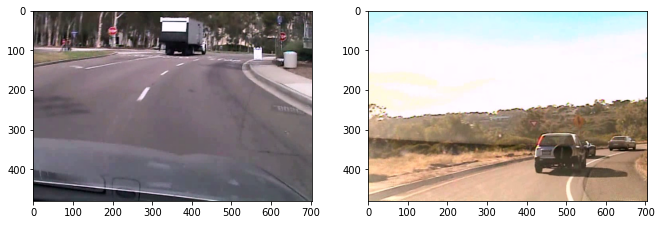

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8
# read images
img_A = mpimg.imread('sample_001.png')
img_B = mpimg.imread('sample_356.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)

Die Informationen zum Bild und die Labels sind in einer CSV-Datei gespeichert. Hier ein Auszug aus dieser Datei:

In [11]:
import pandas as pd
pd.read_csv("annotations.csv")

,filename,x1,y1,x2,y2,class
0,sample_001.png,190,40,211,63,stop
1,sample_002.png,4,246,43,283,stop
2,sample_003.png,389,286,418,314,stop
3,sample_004.png,307,243,315,251,stop
4,sample_005.png,377,249,398,270,stop
...,...,...,...,...,...,...
895,sample_896.png,534,155,563,187,speedLimit25
896,sample_897.png,526,223,540,240,speedLimit25
897,sample_898.png,633,236,663,269,speedLimit25
898,sample_899.png,407,273,431,300,speedLimit25


#### Dataset Klasse

Das (Ver-)Arbeiten von/mit Datensätzen kann schnell unübersichtlich werden. Dabei bietet PyTorch die Möglichkeit, einen eigenen Datensatz auf Basis der DataSet-Klasse mit einzubinden. Dies ermöglicht unter anderem, dass der Code zur Verarbeitung des Datensatzes entkoppelt ist vom Code zum Training. Des Weiteren ermöglicht die Nutzung der Dataset-Klasse, die eigenen Daten in ein Format zu bringen, welches zum Training verschiedener neuronaler Netze ohne große Umstände genutzt werden kann. 

Bei der Nutzung des Datensatzes, müssen in der Dataset Klasse werden drei Funktionen definiert. 
1. __init__() 

Dabei wird init __init__() einmal bei der Instanziierung des Dataset-Objektes ausgeführt. Dabei findete die initialisierung des Verzechnis mit den Bildern, die Labeldatei und ggf. weiteren Transformationen statt. [Quelle]


2. __getitem__()

Die Funktion __getitem__() lädt eine Probe aus dem Datensatz mit dem angegebenen Index idx und gibt sie zurück. Anhand des Index identifiziert sie den Speicherort des Bildes auf der Festplatte, konvertiert es mit read_image in einen Tensor, ruft die entsprechende Bezeichnung aus den csv-Daten auf, ruft die Transformationsfunktionen für auf und gibt das Tensor-Bild und die entsprechende Bezeichnung in einem Tupel zurück. [Quelle]

3. __len__()

Die Funktion len() gibt die Anzahl der Sampels im verwendeten Datensatz wieder. [Quelle]


In [ ]:
class2id = {"stop": 1, "yield": 2, "yieldAhead": 3, "merge": 4, "signalAhead": 5, "pedestrianCrossing": 6, "keepRight": 7, "speedLimit35": 8, "speedLimit25":9}
# dataset definition
class myDataset(Dataset):
    # load the dataset
    def __init__(self,root,transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "imgs"))))
        self.data = pd.read_csv(os.path.join(self.root, "annotations.csv"))
    # get a row at an index
    def __getitem__(self, idx):
        idx = idx -1
        img_path = os.path.join(self.root, "imgs", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        row = self.data.iloc[idx]
        
        boxes = []
        
        x1 = int(row[1])
        y1 = int(row[2])
        x2 = int(row[3])
        y2 = int(row[4])
        label = class2id[row[5]]
        boxes.append([x1, y1, x2, y2])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor([label], dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = torch.tensor([False])
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    
    def __len__(self):
        return len(self.imgs)